In [1]:
import pandas as pd
import numpy as np
from langdetect import detect as langdetect
import random
seed = 42
np.random.seed(seed)
random.seed(seed)
import sys
sys.path.append("../..")
from data.labeled import CWA as cwa, CWR as cwr

# Preprocess whole dataset

In [2]:
cwa.head()

,Account No,Organisation,City,Country,Region,Access,C40,Reporting Year,Risks to city's water supply,Adaptation action,Action description,City Location
0,1093,City of Atlanta,Atlanta,United States of America,North America,public,NaN,2018,Increased water stress or scarcity,Investment in existing water supply infrastruc...,"The city is building a new reservoir, fixing t...","(33.749, -84.388)"
1,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Conservation awareness and education,NaN,"(30.2672, -97.7431)"
2,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Conservation incentives,NaN,"(30.2672, -97.7431)"
3,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Water use restrictions,NaN,"(30.2672, -97.7431)"
4,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Efficiency regulations or standards,NaN,"(30.2672, -97.7431)"


In [3]:
cwr.head()

,Account No,Organisation,City,Country,Region,Access,C40,Reporting year,Risks to city's water supply,Timescale,Magnitude,Risk description,Current population,Population year,City Location
0,1093,City of Atlanta,Atlanta,United States of America,North America,public,NaN,2018,Increased water stress or scarcity,Short-term,Serious,The city depends on one river for water supply...,450182.0,2017,"(33.749, -84.388)"
1,1093,City of Atlanta,Atlanta,United States of America,North America,public,NaN,2018,Higher water prices,Current,Serious,The water cost burden is felt across all ZIP c...,450182.0,2017,"(33.749, -84.388)"
2,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Medium-term,Extremely serious,NaN,1265974.0,2017,"(30.2672, -97.7431)"
3,1499,Ajuntament de Barcelona,Barcelona,Spain,Europe,public,C40,2018,Increased water stress or scarcity,Current,Extremely serious,The downscaling of the climate projections at ...,1604555.0,2015,"(41.3823, 2.1775)"
4,1499,Ajuntament de Barcelona,Barcelona,Spain,Europe,public,C40,2018,Declining water quality,Medium-term,Serious,A reduction in water resources availability c...,1604555.0,2015,"(41.3823, 2.1775)"


## Normalize columns names

In [4]:
# Convert columns names to lowercase
cwa.columns = cwa.columns.str.lower().str.replace(" ", "_").str.replace("'","")
cwr.columns = cwr.columns.str.lower().str.replace(" ", "_").str.replace("'","")

## Find counts of nulls per column

In [5]:
cwr.isnull().sum()

account_no                       0
organisation                     0
city                             0
country                          0
region                           0
access                           0
c40                            504
reporting_year                   0
risks_to_citys_water_supply     40
timescale                       11
magnitude                      159
risk_description               107
current_population               0
population_year                  0
city_location                    0
dtype: int64

In [6]:
cwa.isnull().sum()

account_no                       0
organisation                     0
city                             0
country                          0
region                           0
access                           0
c40                            536
reporting_year                   0
risks_to_citys_water_supply     75
adaptation_action               19
action_description             146
city_location                    0
dtype: int64

## Find columns that exist in both datasets

In [7]:
id_columns = list(set(cwr.columns) & set(cwa.columns))
id_columns

['region',
 'city',
 'country',
 'c40',
 'access',
 'reporting_year',
 'risks_to_citys_water_supply',
 'account_no',
 'city_location',
 'organisation']

## Check how many nulls exist in these columns

In [8]:
cwr[id_columns].isnull().sum()

region                           0
city                             0
country                          0
c40                            504
access                           0
reporting_year                   0
risks_to_citys_water_supply     40
account_no                       0
city_location                    0
organisation                     0
dtype: int64

In [9]:
cwa[id_columns].isnull().sum()

region                           0
city                             0
country                          0
c40                            536
access                           0
reporting_year                   0
risks_to_citys_water_supply     75
account_no                       0
city_location                    0
organisation                     0
dtype: int64

## Replace nulls there with "nan" strings, so that merging is done correctly

In [10]:
cwr['c40'] = cwr['c40'] == 'C40'
cwr[id_columns] = cwr[id_columns].fillna('nan')

In [11]:
cwa['c40'] = cwa['c40'] == 'C40'
cwa[id_columns] = cwa[id_columns].fillna('nan')

## Check id_columns uniqueness

In [12]:
len(cwa[id_columns]), len(cwa[id_columns].drop_duplicates())


(685, 484)

In [13]:
len(cwr[id_columns]), len(cwr[id_columns].drop_duplicates())

(608, 578)

## Aggregate by grouping by id_columns and applying set operations to other colums

In [14]:
cwa_agg = cwa.groupby(id_columns).agg(set).reset_index()
cwr_agg = cwr.groupby(id_columns).agg(set).reset_index()

## Make sure that risks magnitude (which is going to be used as an entry label) has a single value 

In [15]:
cwr_agg.magnitude = cwr_agg.magnitude.apply(lambda x: 'Extremely serious' if 'Extremely serious' in x  else ('Serious' if 'Serious' in x else list(x)[0]))

In [16]:
cwr_agg.magnitude.unique()

array([nan, 'Serious', 'Extremely serious', 'Less Serious'], dtype=object)

## Merge (outer) datasets and find the columns that are set (list_columns)
filling the non-merged rows with {np.nan} on list_columns to make sure there is contingency in each column

In [17]:
cw_data = pd.merge(cwa_agg, cwr_agg, on=id_columns, how='outer')
list_columns = cw_data.iloc[0].apply(lambda x: isinstance(x, set))
list_columns = list_columns[list_columns].index
cw_data[list_columns] = cw_data[list_columns].applymap(lambda x: {np.nan} if pd.isna(x) else x)

In [18]:
cw_data.head()

,region,city,country,c40,access,reporting_year,risks_to_citys_water_supply,account_no,city_location,organisation,adaptation_action,action_description,timescale,magnitude,risk_description,current_population,population_year
0,Africa,Abuja,Nigeria,False,public,2018,Higher water prices,36043,"(9.07647, 7.39857)",Abuja Federal Capital Territory,{Water metering},{nan},{Short-term},NaN,{nan},{2440000.0},{2017}
1,Africa,Abuja,Nigeria,False,public,2018,Inadequate or aging infrastructure,36043,"(9.07647, 7.39857)",Abuja Federal Capital Territory,{Investment in existing water supply infrastru...,{nan},{nan},NaN,{nan},{nan},{nan}
2,Africa,Abuja,Nigeria,False,public,2018,Increased water stress or scarcity,36043,"(9.07647, 7.39857)",Abuja Federal Capital Territory,{Efficiency regulations or standards},{nan},{Short-term},NaN,{nan},{2440000.0},{2017}
3,Africa,BouakÃ©,CÃ´te d'Ivoire,False,public,2018,Declining water quality,831617,"(7.4137, -5.0149)",Commune de BouakÃ©,{Diversifying water supply (including new sour...,{Approvisionnement en eau potable par la const...,{Current},Extremely serious,{La ville manque d'eau depuis plus de 5 mois},{715435.0},{2013}
4,Africa,Cape Town,South Africa,True,public,2018,Increased water stress or scarcity,35858,"(-33.9253, 18.4239)",City of Cape Town,"{Water metering, Use of non-potable water outs...",{In terms of diversifying water supply (includ...,{Current},Extremely serious,{The City has generally been able to successfu...,{4174510.0},{2017}


## Extract longitude and latitude from city_location

In [19]:
cw_data['city_location'] = cw_data['city_location'].apply(eval)
cw_data['latitude'] = cw_data['city_location'].apply(lambda x: x[0])
cw_data['longitude'] = cw_data['city_location'].apply(lambda x: x[1])
id_columns = [x for x in id_columns] + ['latitude','longitude']


## Find list columns that are singular (every element contains a length 1 list)

In [20]:
cw_value_columns = [ x for x in cw_data.columns if x not in id_columns]
# Values that can be converted back to strings from sets

singular_cols = cw_data.set_index(id_columns)[list_columns].applymap(lambda x: len(x)==1).product() > 0
singular_cols

adaptation_action     False
action_description    False
timescale             False
risk_description      False
current_population     True
population_year        True
dtype: bool

## Convert singular columns to non list ones

In [21]:
# magnitude is nicely singular per id
cw_data.loc[:, singular_cols[singular_cols].index] = cw_data.loc[:, singular_cols[singular_cols].index].applymap(lambda x: list(x)[0])
list_columns = [x for x in list_columns if x not in singular_cols[singular_cols].index]

## Remove entries that are invalid or in different language than English from the list columns
**also convert sets to lists**

In [22]:
def try_lang_detect_except(x):
    try:
        return (langdetect(x)=='en')
    except:
        return False
cw_data = cw_data.applymap(lambda x: [t for t in x if not pd.isnull(t)  and  (t!='') and (t!='ERROR: #NAME?') and try_lang_detect_except(t)] if isinstance(x,set) else x)

## Fix specific risks annotations by inspection

In [23]:
cw_data.risks_to_citys_water_supply.unique()

array(['Higher water prices', 'Inadequate or aging infrastructure',
       'Increased water stress or scarcity', 'Declining water quality',
       'nan', 'Increased water demand', 'Regulatory',
       'Energy supply issues', 'Inadequate or ageing infrastructure',
       'Declining water quality: Declining water quality'], dtype=object)

In [24]:
cw_data.risks_to_citys_water_supply = cw_data.risks_to_citys_water_supply.apply(lambda x: x.replace('Inadequate or ageing infrastructure','Inadequate or aging infrastructure'))
cw_data['risks_to_citys_water_supply'] = cw_data['risks_to_citys_water_supply'].apply(lambda x: x.replace('Declining water quality: Declining water quality', 'Declining water quality'))
cw_data.risks_to_citys_water_supply.unique()

array(['Higher water prices', 'Inadequate or aging infrastructure',
       'Increased water stress or scarcity', 'Declining water quality',
       'nan', 'Increased water demand', 'Regulatory',
       'Energy supply issues'], dtype=object)

In [25]:
cw_data.head()

,region,city,country,c40,access,reporting_year,risks_to_citys_water_supply,account_no,city_location,organisation,adaptation_action,action_description,timescale,magnitude,risk_description,current_population,population_year,latitude,longitude
0,Africa,Abuja,Nigeria,False,public,2018,Higher water prices,36043,"(9.07647, 7.39857)",Abuja Federal Capital Territory,[],[],[Short-term],NaN,[],2440000.0,2017.0,9.07647,7.39857
1,Africa,Abuja,Nigeria,False,public,2018,Inadequate or aging infrastructure,36043,"(9.07647, 7.39857)",Abuja Federal Capital Territory,[Investment in existing water supply infrastru...,[],[],NaN,[],NaN,NaN,9.07647,7.39857
2,Africa,Abuja,Nigeria,False,public,2018,Increased water stress or scarcity,36043,"(9.07647, 7.39857)",Abuja Federal Capital Territory,[Efficiency regulations or standards],[],[Short-term],NaN,[],2440000.0,2017.0,9.07647,7.39857
3,Africa,BouakÃ©,CÃ´te d'Ivoire,False,public,2018,Declining water quality,831617,"(7.4137, -5.0149)",Commune de BouakÃ©,[Diversifying water supply (including new sour...,[],[],Extremely serious,[],715435.0,2013.0,7.41370,-5.01490
4,Africa,Cape Town,South Africa,True,public,2018,Increased water stress or scarcity,35858,"(-33.9253, 18.4239)",City of Cape Town,"[Use of non-potable water outside, Stormwater ...",[In terms of diversifying water supply (includ...,[],Extremely serious,[The City has generally been able to successfu...,4174510.0,2017.0,-33.92530,18.42390


## Drop metadata columns that will not be used

In [26]:
to_drop = ['timescale','current_population','population_year']
cw_data.drop(columns=['timescale','current_population','population_year'],inplace=True)

## Generate for each of the  list columns a new one that contains the number of elements
**Create value_columns that contains the names of all the list columns + the created ones**

In [27]:
value_columns = set([x for x in cw_value_columns if x not in to_drop] + ['risks_to_citys_water_supply'])
list_columns = cw_data.iloc[0].apply(lambda x: isinstance(x, list))
list_columns = list_columns[list_columns].index
len_columns = set()
for x in value_columns.copy():
    if x in list_columns:
        cw_data[x+'_n'] = cw_data[x].apply(lambda x: len(x) if x else 1)
        len_columns.add(x+'_n')
value_columns = value_columns.union(len_columns)
value_columns

{'action_description',
 'action_description_n',
 'adaptation_action',
 'adaptation_action_n',
 'magnitude',
 'risk_description',
 'risk_description_n',
 'risks_to_citys_water_supply'}

# Filter by C40
**We are making the assumption that, given that those cities participate in a specific program, they will also have better structured data. So this subset will be used as a reference for the imputation**

In [28]:
c40_data = cw_data[cw_data['c40']].copy()
c40_data.shape

(112, 19)

## Find the null percentage of list columns

In [29]:
list_nulls = c40_data[list_columns].applymap(lambda x: len(x) == 0)
list_nulls.mean()

adaptation_action     0.366071
action_description    0.464286
risk_description      0.366071
dtype: float64

In [30]:
c40_data['magnitude'].unique()

array(['Extremely serious', nan, 'Serious', 'Less Serious'], dtype=object)

## Create a report of the values of magnitude

In [31]:
c40_risks = c40_data[id_columns+['magnitude']].copy()
c40_risks['low'] = c40_risks['magnitude'] == 'Less Serious'
c40_risks['medium'] = c40_risks['magnitude'] == 'Serious'
c40_risks['high'] = c40_risks['magnitude'] == 'Extremely serious'
c40_risks['unknown'] = c40_risks['magnitude'].isna()
c40_risks = c40_risks.drop(columns=['magnitude']).groupby([x for x in id_columns if x!="risks_to_citys_water_supply"]).agg(sum).reset_index()
c40_risks

,region,city,country,c40,access,reporting_year,account_no,city_location,organisation,latitude,longitude,low,medium,high,unknown
0,Africa,Addis Ababa,Ethiopia,True,public,2018,31146,"(9.02887, 38.7544)",Addis Ababa City Administration,9.02887,38.75440,0,3,0,0
1,Africa,Cape Town,South Africa,True,public,2018,35858,"(-33.9253, 18.4239)",City of Cape Town,-33.92530,18.42390,0,0,1,0
2,Africa,Dar es Salaam,United Republic of Tanzania,True,public,2018,35893,"(-6.79235, 39.2083)",City of Dar es Salaam,-6.79235,39.20830,0,2,0,1
3,Africa,Durban,South Africa,True,public,2018,35863,"(-29.8587, 31.0218)",City of Durban,-29.85870,31.02180,0,0,0,2
4,Africa,Johannesburg,South Africa,True,public,2018,31115,"(-26.2041, 28.0473)",City of Johannesburg,-26.20410,28.04730,0,0,0,1
5,Africa,Lagos,Nigeria,True,public,2018,31167,"(6.52437, 3.3792)",City of Lagos,6.52437,3.37920,0,5,2,1
6,Africa,Nairobi,Kenya,True,public,2018,35913,"(-1.29206, 36.8219)",City of Nairobi,-1.29206,36.82190,0,2,0,0
7,East Asia,Changwon,Republic of Korea,True,public,2018,31186,"(35.1542, 126.949)",Changwon City,35.15420,126.94900,0,1,0,0
8,East Asia,Dalian,China,True,public,2018,54298,"(38.9389, 121.567)",Dalian Municipal People's Government,38.93890,121.56700,0,0,0,2
9,East Asia,Hong Kong,"China, Hong Kong Special Administrative Region",True,public,2018,31169,"(22.2881, 114.14)",Government of Hong Kong Special Administrative...,22.28810,114.14000,1,1,0,1


In [32]:
from sklearn.preprocessing import LabelEncoder

In [33]:
from utils.nlp import SimilarityAnalysis, create_sim_vector

In [34]:
c40_data.risks_to_citys_water_supply = c40_data.risks_to_citys_water_supply.apply(lambda x: np.nan if x=='nan' else x)

In [35]:
c40_data[c40_data.risks_to_citys_water_supply.isnull()]

,region,city,country,c40,access,reporting_year,risks_to_citys_water_supply,account_no,city_location,organisation,adaptation_action,action_description,magnitude,risk_description,latitude,longitude,risk_description_n,action_description_n,adaptation_action_n
21,Africa,Johannesburg,South Africa,True,public,2018,NaN,31115,"(-26.2041, 28.0473)",City of Johannesburg,[Water use restrictions],[A by-law that effects water restrictions is i...,NaN,[],-26.2041,28.0473,1,1,1
71,East Asia,Tokyo,Japan,True,public,2018,NaN,31111,"(35.41, 139.41)",Tokyo Metropolitan Government,[],[Implementing measures against flood],Serious,[],35.4100,139.4100,1,1,1
108,Europe,Oslo,Norway,True,public,2018,NaN,14088,"(59.9139, 10.7522)",City of Oslo,[Stormwater management (natural or man-made in...,[High activity on re-opening urban rivers and ...,NaN,[],59.9139,10.7522,1,4,3
404,North America,"Portland, OR",United States of America,True,public,2018,NaN,14874,"(45.52, -122.682)","City of Portland, OR",[Watershed preservation],[Portland seeks to manage the watershed in way...,NaN,"[Portland has a secondary, redundant, groundwa...",45.5200,-122.6820,1,1,1
454,South and West Asia,Dhaka,Bangladesh,True,public,2018,NaN,50782,"(23.8103, 90.4125)",Dhaka City,[Stormwater management (natural or man-made in...,[Embankment is constructed around Dhaka City t...,NaN,[Increases water born diseases],23.8103,90.4125,1,1,1
456,South and West Asia,Kolkata,India,True,public,2018,NaN,35904,"(22.5726, 88.3639)",Kolkata Metropolitan Area,[Stormwater management (natural or man-made in...,[Channelisation of drains Construction of new ...,NaN,[Kolkata is currently ranked as the third most...,22.5726,88.3639,2,2,2
476,Southeast Asia and Oceania,Jakarta,Indonesia,True,public,2018,NaN,31166,"(-6.1751, 106.865)",Jakarta City Government,[Other: Stormwater management (natural or man ...,[- Restore damaged and lost water ecosystems (...,NaN,[Increased frequency of rain affecting the are...,-6.1751,106.8650,1,1,1


In [36]:
c40_data.risks_to_citys_water_supply.unique()

array(['Increased water stress or scarcity',
       'Inadequate or aging infrastructure', nan,
       'Declining water quality', 'Energy supply issues',
       'Higher water prices', 'Increased water demand', 'Regulatory'],
      dtype=object)

## Fit Similarity Analysis
**per string list column of the value columns, by concatenating strings together. Vectorize all the string list columns based on their in between similarities**


In [37]:
analyses = {x:SimilarityAnalysis() for x in value_columns if x in list_columns}

In [38]:
vectorized = np.hstack([analyses[x].fit_transform(c40_data[x]) for x in analyses])

## Encode magnitude and risks into numerical labels

In [39]:
cols_to_encode =  [x for x in value_columns if x not in list_columns and x not in len_columns]
c40_data[cols_to_encode] = c40_data[cols_to_encode].fillna('nan')
encoders = {x:LabelEncoder().fit(c40_data[x].fillna('nan')) for x in cols_to_encode}

In [40]:
encoded = np.array([encoders[x].transform(c40_data[x]) for x in encoders]).T.astype(float)
for t in range(len(cols_to_encode)):
    encoded[encoded[:,t] == np.where(encoders[cols_to_encode[t]].classes_=='nan')[0]] = np.nan

In [41]:
lab_freqs = c40_data[cols_to_encode].groupby(cols_to_encode,as_index=False).size()
lab_freqs

,risks_to_citys_water_supply,magnitude,size
0,Declining water quality,Less Serious,2
1,Declining water quality,Serious,9
2,Declining water quality,nan,3
3,Energy supply issues,Extremely serious,1
4,Energy supply issues,Serious,1
5,Higher water prices,Extremely serious,1
6,Higher water prices,Less Serious,1
7,Higher water prices,Serious,1
8,Higher water prices,nan,3
9,Inadequate or aging infrastructure,Extremely serious,3


## Create dataset that contains the encoded labels, the vectorized columns and the columns referring the lists lengths

In [42]:
whole = np.hstack([encoded, vectorized, c40_data[len_columns]])

In [43]:
import sys
sys.path.append('..')
from labeled_preprocessing.imputation import LabeledDatasetImputer

## Fit LabeledDatasetImputer and transform dataset
**(LabeledDatasetImputer is a union of two Iterative Imputers , one for labels and one for features)**

In [44]:
imputer = LabeledDatasetImputer(verbose=2,k_features_per_label=0, seed=seed)
continuous_imputed, y = imputer.fit_transform(whole[:,2:], whole[:,:2], ret_imputed_x=True)

Applying feature selection..
Creating imputed X using KNeighborsRegressor..
[IterativeImputer] Completing matrix with shape (112, 205)
[IterativeImputer] Ending imputation round 1/10, elapsed time 2.14
[IterativeImputer] Change: 17.38138431632505, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 2/10, elapsed time 3.75
[IterativeImputer] Change: 11.920637652295014, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 3/10, elapsed time 5.19
[IterativeImputer] Change: 3.104392637558429, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 4/10, elapsed time 6.63
[IterativeImputer] Change: 0.8415462663279819, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 5/10, elapsed time 8.02
[IterativeImputer] Change: 0.9440332167247709, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 6/10, elapsed time 9.50
[IterativeImputer] Change: 1.2595935187934937, scaled tolerance: 0.011 
[IterativeImputer] Ending imputat

/home/vaslem/code/Modern Data Analytics/.venv/lib/python3.8/site-packages/sklearn/impute/_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


[IterativeImputer] Ending imputation round 1/10, elapsed time 0.26
[IterativeImputer] Change: 5.0, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.47
[IterativeImputer] Change: 0.0, scaled tolerance: 0.011 
[IterativeImputer] Early stopping criterion reached.


## Use the prediction power on the imputed data as measurement of coherent imputation.

In [45]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
simple_model = make_pipeline(StandardScaler(), SVC(kernel='linear', C=0.01, random_state=seed))
scoring = 'accuracy' 
scores = cross_val_score(simple_model, continuous_imputed, y[:,cols_to_encode.index('magnitude')], cv=5,scoring=scoring)
np.mean(scores)

0.7411067193675889

## Plot features correlation

(207, 207)


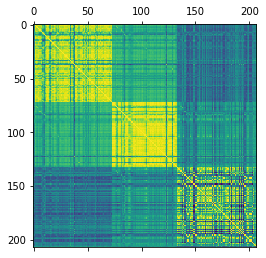

In [46]:
import matplotlib.pyplot as plt
flg = np.all(~np.isnan(whole),axis=1), np.hstack([[True, True], imputer.selection_mask[:]])
corr = np.corrcoef(whole[flg[0],:][:,flg[1]].T)
print(corr.shape)
plt.matshow(corr)

## Retrieve the categorical imputed labels

In [47]:
imputed = np.array([
    encoders[x].inverse_transform(
    y[:, c].astype(int)
 ) for c,x in enumerate(cols_to_encode)]).T

In [48]:
c40_data_imputed = c40_data.copy()

In [49]:
c40_data_imputed[cols_to_encode] = imputed

In [50]:
c40_data_imputed.head()

,region,city,country,c40,access,reporting_year,risks_to_citys_water_supply,account_no,city_location,organisation,adaptation_action,action_description,magnitude,risk_description,latitude,longitude,risk_description_n,action_description_n,adaptation_action_n
4,Africa,Cape Town,South Africa,True,public,2018,Increased water stress or scarcity,35858,"(-33.9253, 18.4239)",City of Cape Town,"[Use of non-potable water outside, Stormwater ...",[In terms of diversifying water supply (includ...,Extremely serious,[The City has generally been able to successfu...,-33.92530,18.4239,1,10,9
7,Africa,Dar es Salaam,United Republic of Tanzania,True,public,2018,Increased water stress or scarcity,35893,"(-6.79235, 39.2083)",City of Dar es Salaam,[Investment in existing water supply infrastru...,[City provide some % of the total money correc...,Serious,[],-6.79235,39.2083,1,1,1
8,Africa,Durban,South Africa,True,public,2018,Increased water stress or scarcity,35863,"(-29.8587, 31.0218)",City of Durban,"[Watershed preservation, Investment in existin...",[A number of innovative approaches have been p...,Serious,[],-29.85870,31.0218,1,3,3
21,Africa,Johannesburg,South Africa,True,public,2018,Increased water stress or scarcity,31115,"(-26.2041, 28.0473)",City of Johannesburg,[Water use restrictions],[A by-law that effects water restrictions is i...,Serious,[],-26.20410,28.0473,1,1,1
24,Africa,Lagos,Nigeria,True,public,2018,Declining water quality,31167,"(6.52437, 3.3792)",City of Lagos,[Water use restrictions],"[Application of water abstraction rules, surch...",Serious,[Increased rainfall will result to greater amo...,6.52437,3.3792,1,1,1


## Find which labels  have been updated after imputation

In [51]:
imp_lab_freqs = c40_data_imputed[cols_to_encode].groupby(cols_to_encode,as_index=False).size()
imp_ret = pd.merge(lab_freqs, imp_lab_freqs,suffixes=('','_imp'), how='right',on=cols_to_encode)
imp_ret['increase'] = (imp_ret['size_imp'] - imp_ret['size'])/imp_ret['size']
imp_ret

,risks_to_citys_water_supply,magnitude,size,size_imp,increase
0,Declining water quality,Less Serious,2,2,0.000000
1,Declining water quality,Serious,9,16,0.777778
2,Energy supply issues,Extremely serious,1,1,0.000000
3,Energy supply issues,Serious,1,1,0.000000
4,Higher water prices,Extremely serious,1,1,0.000000
5,Higher water prices,Less Serious,1,1,0.000000
6,Higher water prices,Serious,1,1,0.000000
7,Inadequate or aging infrastructure,Extremely serious,3,3,0.000000
8,Inadequate or aging infrastructure,Less Serious,2,2,0.000000
9,Inadequate or aging infrastructure,Serious,8,17,1.125000


## Make sure that all risks have been encoded and are imputation outcome candidates 

In [52]:
set([x for x in cw_data['risks_to_citys_water_supply'] if x not in encoders['risks_to_citys_water_supply'].classes_])

set()

# Impute whole dataset

In [53]:
cw_data['risks_to_citys_water_supply'].value_counts()

Increased water stress or scarcity    205
Inadequate or aging infrastructure    180
Declining water quality               127
nan                                    54
Increased water demand                 49
Higher water prices                    38
Regulatory                             17
Energy supply issues                    7
Name: risks_to_citys_water_supply, dtype: int64

## Apply encoding and vectorization
**based on fitted encoders and SimilarityAnalysis objects**

In [54]:
cw_data[cols_to_encode] = cw_data[cols_to_encode].fillna('nan')
encoded = np.array([encoders[x].transform(cw_data[x]) for x in encoders]).T.astype(float)
for t in range(len(cols_to_encode)):
    encoded[encoded[:,t] == np.where(encoders[cols_to_encode[t]].classes_=='nan')[0]] = np.nan

In [55]:
all_vectorized = np.hstack([analyses[x].transform(cw_data[x]) for x in value_columns if x in list_columns])

## Apply imputation
**using the trained imputer**

In [56]:
all_imputed_x, all_imputed_y  = imputer.transform(np.hstack([all_vectorized,cw_data[len_columns]]), encoded, ret_imputed_x=True)

[IterativeImputer] Completing matrix with shape (677, 205)
[IterativeImputer] Ending imputation round 1/10, elapsed time 1.84
[IterativeImputer] Ending imputation round 2/10, elapsed time 3.52
[IterativeImputer] Ending imputation round 3/10, elapsed time 5.33
[IterativeImputer] Ending imputation round 4/10, elapsed time 7.02
[IterativeImputer] Ending imputation round 5/10, elapsed time 8.64
[IterativeImputer] Ending imputation round 6/10, elapsed time 10.43
[IterativeImputer] Ending imputation round 7/10, elapsed time 12.98
[IterativeImputer] Ending imputation round 8/10, elapsed time 15.40
[IterativeImputer] Ending imputation round 9/10, elapsed time 17.50
[IterativeImputer] Ending imputation round 10/10, elapsed time 19.68
[IterativeImputer] Completing matrix with shape (677, 207)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.09
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.12


In [57]:
all_imputed_y_dec = np.array([
    encoders[x].inverse_transform(
    all_imputed_y[:, c].astype(int)
 ) for c,x in enumerate(cols_to_encode)]).T

In [58]:
cw_data_imputed = cw_data.copy()
cw_data_imputed[cols_to_encode] = all_imputed_y_dec

## Plot features correlation

(207, 207)


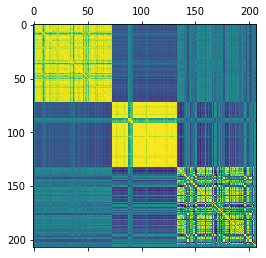

In [59]:
import matplotlib.pyplot as plt
corr = np.corrcoef(np.hstack([all_imputed_y, all_imputed_x]).T)
print(corr.shape)
plt.matshow(corr)

In [60]:
scores = cross_val_score(simple_model, all_imputed_x, all_imputed_y[:,cols_to_encode.index('magnitude')], cv=5,scoring=scoring)
np.mean(scores)

0.7296949891067538

**The score did not have significant drop, so we can assume that the imputation was cohesive across data**

## Create output dataset

In [61]:
final_labeled_data = cw_data_imputed[['city','latitude','longitude','country','c40','region','magnitude','risks_to_citys_water_supply']].copy()
final_labeled_data.rename(columns={'magnitude': 'risk','risks_to_citys_water_supply': 'description'},inplace=True)
final_labeled_data.to_csv("../../data/labeled/processed.csv")

In [62]:
final_labeled_data

,city,latitude,longitude,country,c40,region,risk,description
0,Abuja,9.07647,7.39857,Nigeria,False,Africa,Serious,Inadequate or aging infrastructure
1,Abuja,9.07647,7.39857,Nigeria,False,Africa,Serious,Inadequate or aging infrastructure
2,Abuja,9.07647,7.39857,Nigeria,False,Africa,Serious,Increased water stress or scarcity
3,BouakÃ©,7.41370,-5.01490,CÃ´te d'Ivoire,False,Africa,Extremely serious,Declining water quality
4,Cape Town,-33.92530,18.42390,South Africa,True,Africa,Extremely serious,Increased water stress or scarcity
...,...,...,...,...,...,...,...,...
672,Ho Chi Minh,10.76260,106.66000,Viet Nam,True,Southeast Asia and Oceania,Less Serious,Inadequate or aging infrastructure
673,Ho Chi Minh,10.76260,106.66000,Viet Nam,True,Southeast Asia and Oceania,Less Serious,Increased water demand
674,Jakarta,-6.17510,106.86500,Indonesia,True,Southeast Asia and Oceania,Serious,Inadequate or aging infrastructure
675,New Plymouth District,-39.10110,174.35400,New Zealand,False,Southeast Asia and Oceania,Serious,Inadequate or aging infrastructure


## See a report of the filled labels

In [63]:
cw_lab_freqs = cw_data[cols_to_encode].groupby(cols_to_encode,as_index=False).size()
imp_cw_lab_freqs = cw_data_imputed[cols_to_encode].groupby(cols_to_encode,as_index=False).size()
imp_cw_ret = pd.merge(cw_lab_freqs, imp_cw_lab_freqs,suffixes=('','_imp'), how='right',on=cols_to_encode)
imp_cw_ret['increase'] = (imp_cw_ret['size_imp'] - imp_cw_ret['size'])/imp_cw_ret['size']
imp_cw_ret

,risks_to_citys_water_supply,magnitude,size,size_imp,increase
0,Declining water quality,Extremely serious,23,25,0.086957
1,Declining water quality,Less Serious,18,18,0.000000
2,Declining water quality,Serious,57,112,0.964912
3,Energy supply issues,Extremely serious,1,1,0.000000
4,Energy supply issues,Less Serious,1,1,0.000000
5,Energy supply issues,Serious,5,5,0.000000
6,Higher water prices,Extremely serious,2,2,0.000000
7,Higher water prices,Less Serious,10,10,0.000000
8,Higher water prices,Serious,14,14,0.000000
9,Inadequate or aging infrastructure,Extremely serious,12,13,0.083333


In [64]:
pd.merge(imp_cw_ret, imp_ret, suffixes=('','_c40'), on=('magnitude','risks_to_citys_water_supply'))

,risks_to_citys_water_supply,magnitude,size,size_imp,increase,size_c40,size_imp_c40,increase_c40
0,Declining water quality,Less Serious,18,18,0.000000,2,2,0.000000
1,Declining water quality,Serious,57,112,0.964912,9,16,0.777778
2,Energy supply issues,Extremely serious,1,1,0.000000,1,1,0.000000
3,Energy supply issues,Serious,5,5,0.000000,1,1,0.000000
4,Higher water prices,Extremely serious,2,2,0.000000,1,1,0.000000
5,Higher water prices,Less Serious,10,10,0.000000,1,1,0.000000
6,Higher water prices,Serious,14,14,0.000000,1,1,0.000000
7,Inadequate or aging infrastructure,Extremely serious,12,13,0.083333,3,3,0.000000
8,Inadequate or aging infrastructure,Less Serious,18,19,0.055556,2,2,0.000000
9,Inadequate or aging infrastructure,Serious,48,123,1.562500,8,17,1.125000
